<a href="https://colab.research.google.com/github/jashvidesai/ORF-Thesis/blob/main/Heterogenous_VRPTW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 111.9 MB/s eta 0:00:00


In [3]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

In [4]:
# Example parameters
V = range(8)  # nodes including depot, 0 is depot
V_star = range(1, 8)  # nodes excluding depot
K = range(4)  # three vehicles with heterogeneous capacities
Q = [25, 30, 35, 30]  # capacity of each vehicle
vehicle_speed = 60  # vehicle speed in km/h
fixed_costs = [50, 70, 90, 70]  # Example fixed costs

# DISTANCES

np.random.seed(42)
distances = np.random.randint(10, 51, size=(len(V), len(V)))
for i in V:
    distances[i, i] = 0
    for j in range(i + 1, len(V)):
        distances[j, i] = distances[i, j]
for i in V:
    for j in V:
        for k in V:
            if distances[i, j] > distances[i, k] + distances[k, j]:
                distances[i, j] = distances[i, k] + distances[k, j]


t = distances / vehicle_speed  # travel times
c = distances * 0.093  # travel costs (arbitrary scaling for fuel)

# Sample demands (including depot which has 0 demand)
d = [0, 8, 10, 12, 15, 18, 20, 25]

# Time window parameters
a = [0, 0, 5, 10, 5, 5, 5, 5]
b = [100, 60, 70, 80, 80, 70, 80, 70]
s = [5, 10, 15, 10, 10, 15, 5, 15]  # service times at each node

# Model setup
model = gp.Model("Heterogeneous_VRPTW")

# Decision variables
x = model.addVars(V, V, K, vtype=GRB.BINARY, name="x")  # binary: whether vehicle k travels from i to j
q = model.addVars(V, K, vtype=GRB.CONTINUOUS, name="q")  # continuous: cumulative demand on vehicle k at node i
tau = model.addVars(V, K, vtype=GRB.CONTINUOUS, name="tau")  # continuous: arrival time of vehicle k at node i

# Objective: Minimize total travel cost
model.setObjective(
    gp.quicksum(c[i, j] * x[i, j, k] for i in V for j in V for k in K if i != j) +
    gp.quicksum(fixed_costs[k] * gp.quicksum(x[0, j, k] for j in V_star) for k in K),
    GRB.MINIMIZE
)

# Constraints

# Each customer is visited exactly once by any vehicle
model.addConstrs(
    (gp.quicksum(x[i, j, k] for i in V for k in K) == 1 for j in V_star),
    name="visit_customer_once"
)

# Each node is departed from exactly once by any vehicle
model.addConstrs(
    (gp.quicksum(x[i, j, k] for j in V for k in K) == 1 for i in V_star),
    name="departure_from_node_once"
)

###

# Ensure each vehicle returns to the depot at most once
model.addConstrs(
    (gp.quicksum(x[i, 0, k] for i in V_star) == 1 for k in K),
    name="vehicle_return_depot_once"
)

# Ensure each vehicle departs the depot at most once
model.addConstrs(
    (gp.quicksum(x[0, j, k] for j in V_star) == 1 for k in K),
    name="vehicle_depart_depot_once"
)

###

# Flow conservation for all nodes and vehicles
model.addConstrs(
    (gp.quicksum(x[i, j, k] for i in V if j != i) == gp.quicksum(x[j, i, k] for i in V if j != i)
    for j in V_star for k in K),
    name="flow_conservation"
)

# no self-loops
model.addConstrs(
    (x[i, i, k] == 0 for i in V for k in K),
    name="no_self_loops"
)

# Depot load initialization
model.addConstrs(
    (q[0, k] == 0 for k in K),
    name="depot_load"
)

# Load boundaries
model.addConstrs(
    (q[i, k] >= d[i] for i in V_star for k in K),
    name="load_lower_bound"
)
model.addConstrs(
    (q[i, k] <= Q[k] for i in V_star for k in K),
    name="load_upper_bound"
)

# Cumulative load progression - Upper Bound
model.addConstrs(
    (q[i, k] + d[j] <= q[j, k] + Q[k] * (1 - x[i, j, k])
     for i in V_star for j in V_star for k in K if i != j),
    name="load_progression_upper"
)

# Cumulative load progression - Lower Bound
M = {(i, j, k): Q[k] - (d[i] + d[j]) for i in V_star for j in V_star for k in K if i != j}
model.addConstrs(
    (q[i, k] + d[j] >= q[j, k] - M[i, j, k] * (1 - x[i, j, k])
     for i in V_star for j in V_star for k in K if i != j),
    name="load_progression_lower"
)

# Depot time
model.addConstrs(
    (tau[0, k] == 0 for k in K),
    name="depot_time"
)

# Time window bounds
model.addConstrs(
    (a[i] <= tau[i, k] for i in V_star for k in K),
    name="time_window_start"
)
model.addConstrs(
    (tau[i, k] <= b[i] for i in V_star for k in K),
    name="time_window_end"
)

# Service time and travel time continuity
M_2 = {(i, j, k): b[i] - a[j] + s[i] + t[i, j] for i in V_star for j in V_star for k in K if i != j}
model.addConstrs(
    (tau[i, k] + s[i] + t[i, j] <= tau[j, k] + M_2[i, j, k] * (1 - x[i, j, k])
     for i in V_star for j in V_star for k in K if i != j),
    name="service_time"
)

# Solve the model
model.optimize()

# Output results
if model.status == GRB.OPTIMAL:
    print("\nOptimal Solution Found:\n")
    for k in K:
        print(f"--- Routes for Vehicle {k} ---")
        route = [0]  # Start at the depot
        total_cost = 0
        current_node = 0  # Start at depot

        while True:
            found_next = False
            for j in V:  # Look for the next node in the route
                if x[current_node, j, k].x > 0.5 and current_node != j:  # Check valid edge
                    route.append(j)  # Add the node to the route
                    total_cost += c[current_node, j]  # Add travel cost
                    current_node = j  # Move to the next node
                    found_next = True
                    break

            if not found_next or current_node == 0:
                # If no valid next node is found or we return to depot, stop
                break

        # Print the route and cost if the vehicle served at least one customer
        if len(route) > 2:  # Route includes at least one customer
            route.append(0)  # Add the depot at the end
            print(f"Vehicle {k} route: {' -> '.join(map(str, route))}")
            print(f"Total cost for Vehicle {k}: {total_cost:.2f}")
        else:
            print(f"Vehicle {k} is not used.")

    print("\n")
else:
    print("No optimal solution found.")

# Check if demand is fulfilled
print("Demand Fulfillment at Nodes:")
for i in V_star:
    total_demand_fulfilled = sum(q[i, k].x for k in K)  # Total demand satisfied at node i
    print(f"Node {i}: Demand = {d[i]}, Fulfilled = {total_demand_fulfilled:.2f}")

# Check if vehicles are used
print("Vehicle Usage:")
for k in K:
    used = any(x[i, j, k].x > 0.5 for i in V for j in V if i != j)
    print(f"Vehicle {k}: {'Used' if used else 'Not Used'}")

# Print raw decision variables
print("\nDecision Variables:")
for k in K:
    for i in V:
        for j in V:
            if x[i, j, k].x > 0.5:
                print(f"x[{i}, {j}, {k}] = {x[i, j, k].x}")

Restricted license - for non-production use only - expires 2026-11-23
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 706 rows, 320 columns and 2546 nonzeros
Model fingerprint: 0xff8d076d
Variable types: 64 continuous, 256 integer (256 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [1e+00, 9e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+01]
Presolve removed 417 rows and 137 columns
Presolve time: 0.01s
Presolved: 289 rows, 183 columns, 2215 nonzeros
Variable types: 46 continuous, 137 integer (137 binary)

Root relaxation: objective 3.036007e+02, 57 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Tim

In [5]:
import matplotlib.pyplot as plt
import networkx as nx

# Visualization function
def visualize_routes(V, V_star, K, distances, x, q, fixed_costs, d):
    # Create the graph
    G = nx.DiGraph()

    # Add nodes
    for i in V:
        G.add_node(i, demand=d[i])

    # Add edges for all vehicles
    edge_colors = ['red', 'blue', 'green', 'purple']
    for k in K:
        for i in V:
            for j in V:
                if i != j and x[i, j, k].x > 0.5:
                    G.add_edge(i, j, vehicle=k, weight=distances[i][j])

    # Node positions (circle layout)
    pos = nx.circular_layout(G)

    # Draw nodes
    node_colors = ['orange' if i == 0 else 'lightblue' for i in V]
    node_labels = {i: f"{i}\n(Demand: {d[i]})" for i in V}
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=700)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10)

    # Draw edges
    for k in K:
        edges_k = [(i, j) for i, j in G.edges if G[i][j]['vehicle'] == k]
        nx.draw_networkx_edges(G, pos, edgelist=edges_k, edge_color=edge_colors[k], width=2, label=f"Vehicle {k}")

    # Draw edge labels (travel costs)
    edge_labels = {(i, j): f"{distances[i][j]}" for i, j in G.edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    # Add legend and title
    plt.legend(loc='upper right', fontsize=10)
    plt.title("Vehicle Routing Network and Routes")
    plt.show()

    # Print additional information
    print("\nAdditional Information:")
    for k in K:
        print(f"Vehicle {k}: Fixed Cost = {fixed_costs[k]}")
        route_demand = sum(d[i] for i in V_star if sum(x[i, j, k].x for j in V) > 0)
        print(f"  Total Demand Fulfilled by Vehicle {k}: {route_demand}")
        print(f"  Total Capacity: {Q[k]}\n")

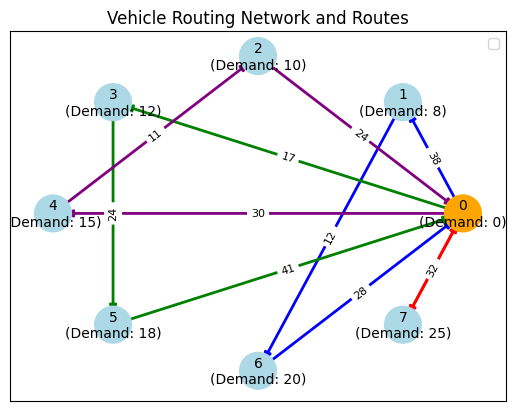


Additional Information:
Vehicle 0: Fixed Cost = 50
  Total Demand Fulfilled by Vehicle 0: 25
  Total Capacity: 25

Vehicle 1: Fixed Cost = 70
  Total Demand Fulfilled by Vehicle 1: 28
  Total Capacity: 30

Vehicle 2: Fixed Cost = 90
  Total Demand Fulfilled by Vehicle 2: 30
  Total Capacity: 35

Vehicle 3: Fixed Cost = 70
  Total Demand Fulfilled by Vehicle 3: 25
  Total Capacity: 30



In [6]:
visualize_routes(V, V_star, K, distances, x, q, fixed_costs, d)